In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [26]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, UpSampling2D, Conv2D
from tensorflow.keras.layers import Flatten, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

from PIL import Image
from tqdm import tqdm

import os 
import time
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [27]:
# Resolution 
gen_image_size = 96
no_channels = 3

# Size of vector to generate images
Seed_Size = 100

# Config - EPOCH, Batch and buffer size
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [28]:
# Path for data from Google Drive

DATA_PATH = '/content/drive/My Drive/projects/Generator_crawl_outside'

# Creating numpy binary file to store preprocessed images for quicker loading
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_96_96.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  path = os.path.join(DATA_PATH,'Generator_crawl')
  for filename in tqdm(os.listdir(path)):
      path = os.path.join(path,filename)
      image = Image.open(path).resize((gen_image_size,
            gen_image_size),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  x = training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))
  
  training_data = np.reshape(training_data,(-1,gen_image_size,
            gen_image_size,no_channels))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start

else:
  print("Loading previous training npy...")
  training_data = np.load(training_binary_path)


Looking for file: /content/drive/My Drive/projects/Generator_crawl_outside/training_data_96_96.npy
Loading previous training npy...


In [29]:
#Size of Training Data
training_data.shape[0]

1360

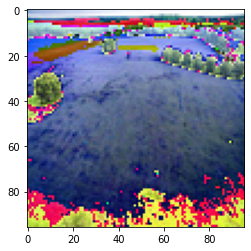

In [30]:
i = 58
x = np.reshape(training_data[i], (96,96,3))
img = x * 255
img = img.astype(np.uint8)
im = Image.fromarray(img)
plt.imshow(im)

In [31]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
"""#train_dataset
training_data = tf.range(10)
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(5).batch(2)
def print_values():
    for val in train_dataset:
        print(val.numpy(), end=" ")
    print()
print_values()"""

In [32]:
# Building the Generator

def build_generator(seed_size, channels):
  model = Sequential()

  model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
  model.add(Reshape((4,4,256)))

  model.add(UpSampling2D())
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D())
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D())
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D(size=(3,3)))
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))  

  # Final CNN layer
  model.add(Conv2D(channels,kernel_size=3,padding="same"))
  model.add(Activation("tanh"))

  return model

In [33]:
def build_discriminator(image_shape):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model


In [34]:
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
GENERATE_SQUARE = gen_image_size

def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

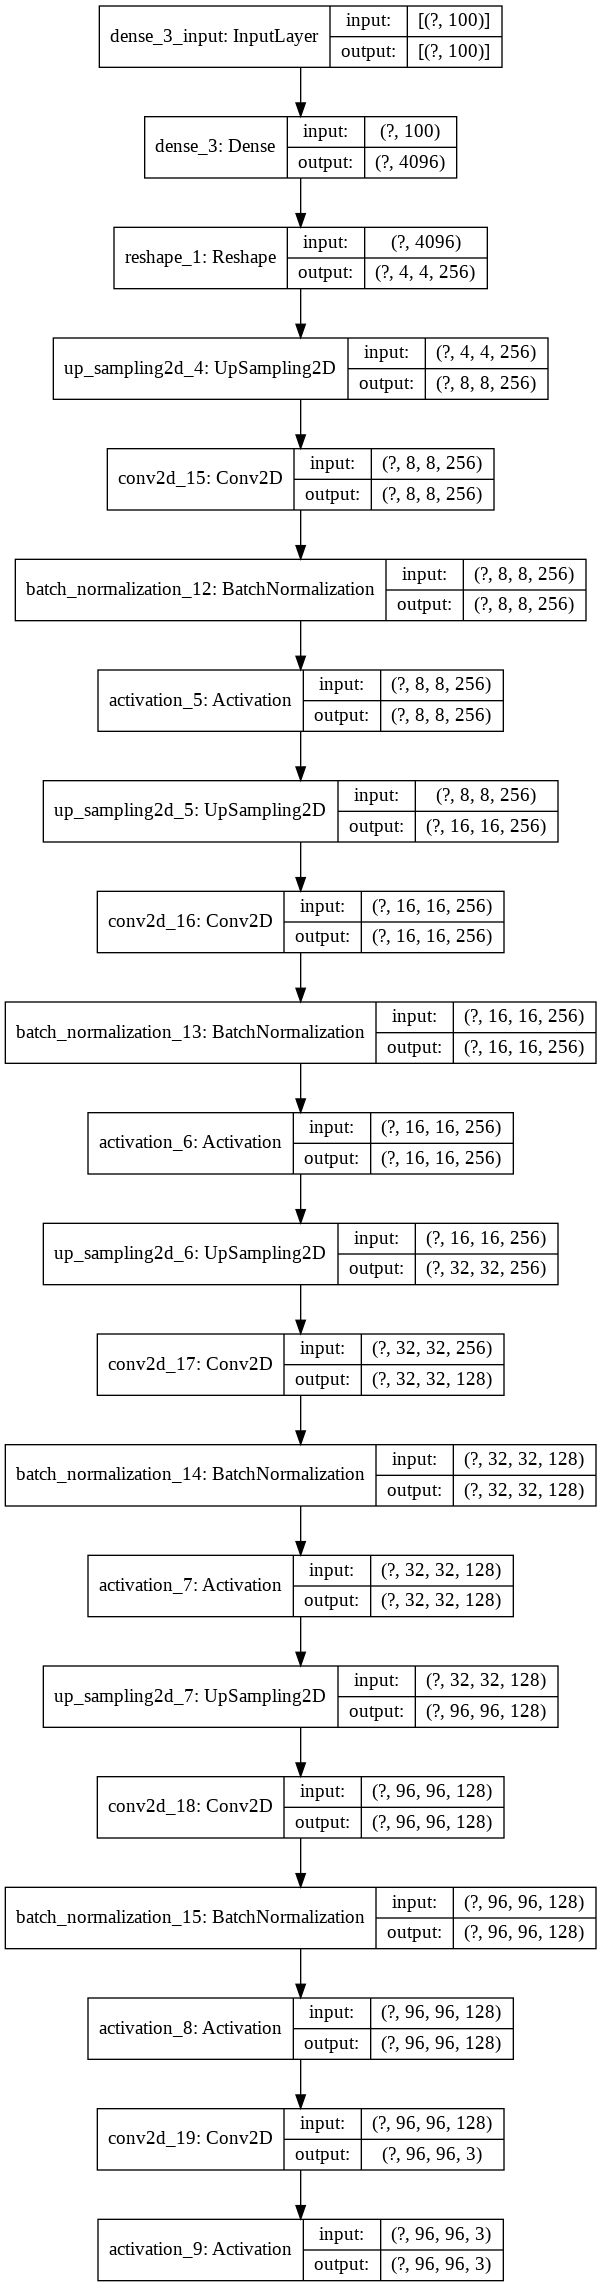

In [35]:
# Structure of the Generator
generator = build_generator(Seed_Size, no_channels)
plot_model(generator, show_shapes=True, to_file='generator.png')

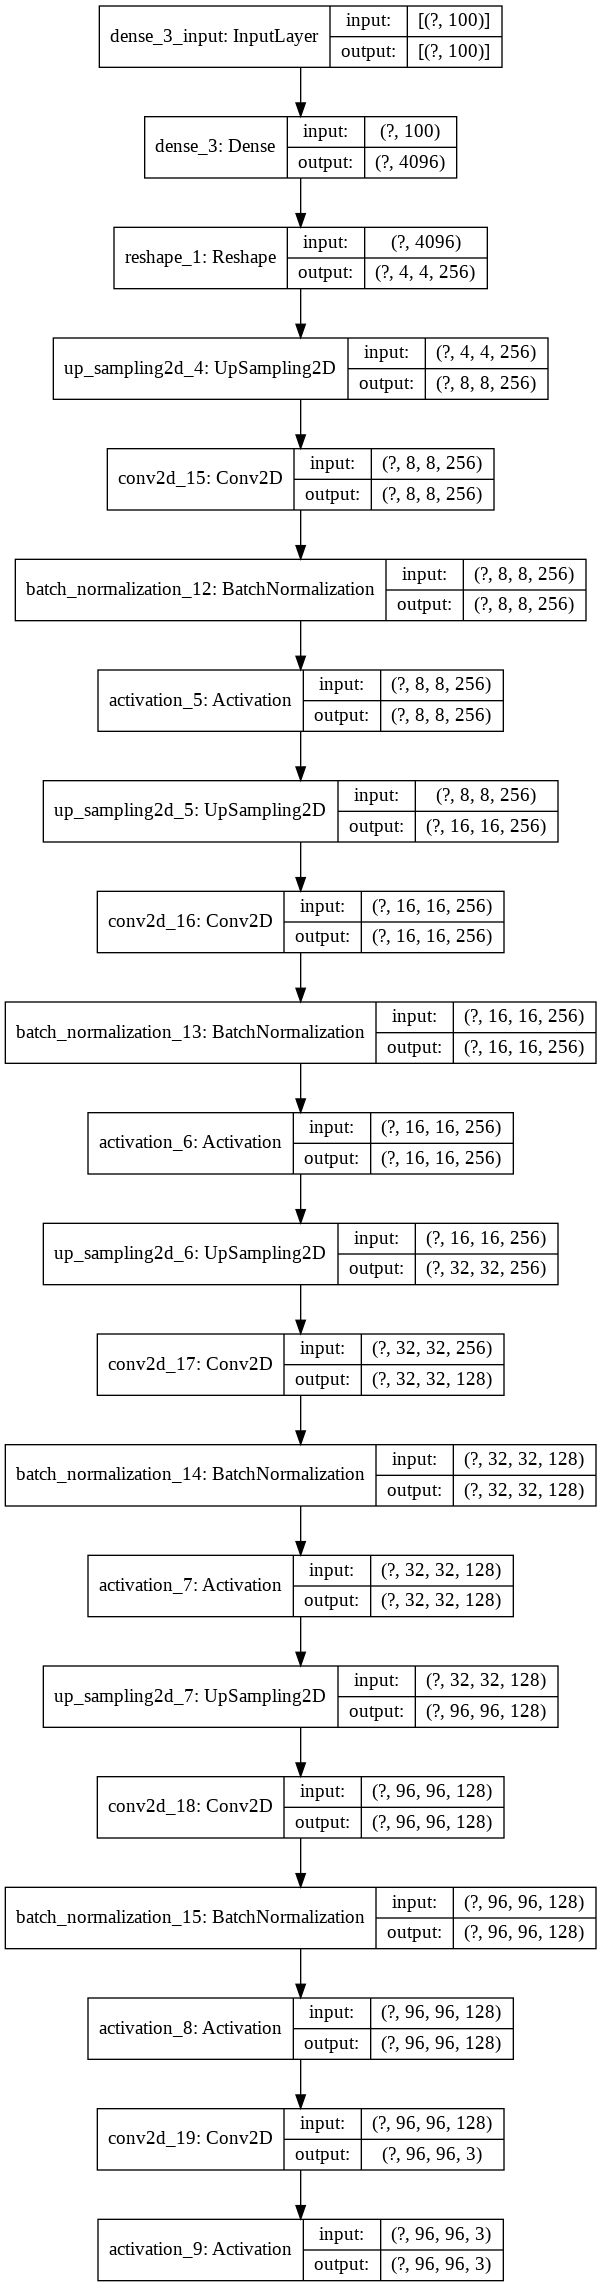

In [36]:
# Structure of the Discriminator
image_shape = (gen_image_size,gen_image_size,no_channels)
discriminator = build_discriminator(image_shape)
plot_model(generator, show_shapes=True, to_file='discriminator.png')

In [37]:
# Computing the discriminator and generator loss (cross entropy loss)

cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
# Optimizer definition, Hyper parameters - learning rate and momentum

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, Seed_Size])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss  



In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       Seed_Size))


  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    
    save_images(epoch,fixed_seed)


In [39]:
# formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=1.9658352136611938,disc loss=1.0117655992507935, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=2.5629162788391113,disc loss=1.0318678617477417, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=2.4434118270874023,disc loss=1.4446505308151245, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=2.6513278484344482,disc loss=0.9611845016479492, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=2.13187313079834,disc loss=1.3974699974060059, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=2.145505905151367,disc loss=1.464035987854004, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=1.992790699005127,disc loss=1.3263798952102661, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=2.0460548400878906,disc loss=1.3958114385604858, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=2.053990125656128,disc loss=1.224794626235962, {hms_string(epoch_elapsed)}
Epoch 10, gen loss=1.901330590248108,disc loss=1.2709674835205078, {hms_string(epoch_elapsed)}
Epoch 11, gen loss=2.0773792266845703,disc loss=1.1655455

In [ ]:
# Saving the generated images in Drive to use for Classifier Training:

output_path = os.path.join(DATA_PATH,'output_gen_more1')
if not os.path.exists(output_path):
    os.makedirs(output_path)
n=2000
new_seed = np.random.normal(0, 1, (n, SEED_SIZE))

for i in range(n):
  x = np.reshape(new_seed[i], (1, 100))
  generated_images = generator.predict(x)
  generated_images = 0.5 * generated_images + 0.5
  x = np.reshape(generated_images, (96,96,3))
  img = x * 255
  img = img.astype(np.uint8)
  filename = os.path.join(output_path,f"gen-{i}.png")
  im = Image.fromarray(img)
  im.save(filename)


  
